## Incident Resolution Time Dataset (Flag 2)

### Dataset Description

The dataset comprises 500 entries simulating a ServiceNow incidents table, detailing various attributes such as category, state, open and close dates, involved personnel, and incident specifics like description, and priority. It captures incident management activities with fields like 'opened_at', 'closed_at', 'assigned_to', 'short_description', and 'priority', reflecting the operational handling and urgency of issues across different locations and categories.

### Your Task
Goal: Analyze the trend of incident resolution times and identify potential reasons for any observed patterns.

Role: Operations Data Analyst

Difficulty: 3 out of 5 - This analysis involves examining temporal trends and understanding the underlying factors affecting incident resolution times. Devise effective transformation functions.

Category: Incidents Management.

### Import Necessary Libraries
This cell imports all necessary libraries required for the analysis. This includes libraries for data manipulation, data visualization, and any specific utilities needed for the tasks.


In [1]:
import argparse
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas import date_range

## Load Dataset
This cell loads the dataset used in the analysis. The dataset is assumed to be stored in a CSV file and is loaded into a DataFrame. This step includes reading the data from a file path and possibly performing initial observations such as viewing the first few rows to ensure it has loaded correctly.


In [2]:
dataset_path = "csvs/flag-2.csv"
df = pd.read_csv(dataset_path)
df.head()

,caller_id,sys_updated_by,state,closed_at,closed_by,assigned_to,opened_at,number,sys_updated_on,short_description,assignment_group,priority,category
0,Bud Richman,system,Closed,2023-01-02 06:58:00.000000000,Howard Johnson,Beth Anglin,2023-01-01 06:58:00,INC0000000000,2023-01-02 06:58:00.000000000,VPN connection issue,Network,2 - High,Network
1,Don Goodliffe,admin,Closed,2023-01-03 18:04:00.000000000,Beth Anglin,Howard Johnson,2023-01-02 10:52:00,INC0000000001,2023-01-03 18:04:00.000000000,WiFi connectivity issue in the sales department,Network,2 - High,Network
2,David Loo,system,Resolved,2023-01-04 04:04:00.000000000,Luke Wilson,Fred Luddy,2023-01-02 20:52:00,INC0000000002,2023-01-04 04:04:00.000000000,Cannot connect to database,Database,2 - High,Database
3,Don Goodliffe,admin,Closed,2023-01-04 19:04:00.000000000,Luke Wilson,Howard Johnson,2023-01-03 04:40:00,INC0000000003,2023-01-04 19:04:00.000000000,Email system not working properly,Network,2 - High,Software
4,Bud Richman,employee,Resolved,2023-01-06 05:23:59.999999999,Charlie Whitherspoon,Charlie Whitherspoon,2023-01-04 07:48:00,INC0000000004,2023-01-06 05:23:59.999999999,Internet connectivity issue in the Marketing D...,Network,2 - High,Network




### **Question 1**: What is the trend in time to resolution (ttr) over time?

#### Plot the trend of Incident Resolution Times

This cell generates a line plot showing the monthly trend of incident resolution times, providing a visual representation of how the average TTR changes over time.

Text(0.5, 1.0, 'Time to resolution by creation date')

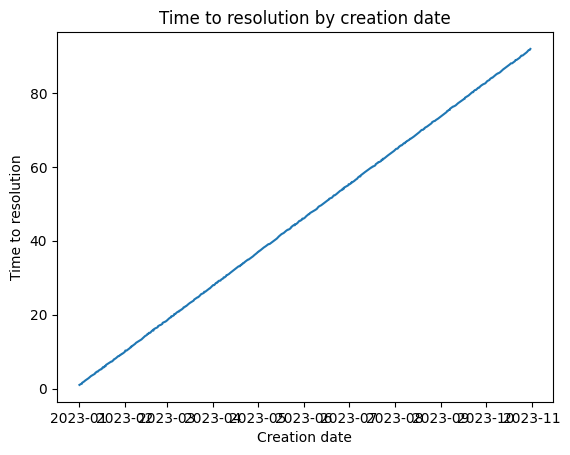

In [3]:
# Convert opened_at and closed_at to datetime
df["opened_at"] = pd.to_datetime(df["opened_at"])
df["closed_at"] = pd.to_datetime(df["closed_at"])
# Compute resolution time in days
df["resolution_time"] = (df["closed_at"] - df["opened_at"]).dt.total_seconds() / 86400

sns.lineplot(x=df["opened_at"], y=df["resolution_time"])
plt.xlabel("Creation date")
plt.ylabel("Time to resolution")
plt.title("Time to resolution by creation date")

#### Generate JSON Description for the Insight


In [4]:
{
"data_type":"diagnostic",
"insight": "The time to resolution of incidents is increasing linearly over time",
"insight_value":{"trend": "increasing"},
"plot": {
    "plot_type": "line",
    "title": "Trend of Time to Resolution (TTR) Over Time",
    "x_axis": {
        "name": "Opened At",
        "description": "This represents the date when the incident was opened."
    },
    "y_axis": {
        "name": "Average TTR (Days)",
        "description": "This represents the average time to resolution (in days) of incidents opened on a particular date."
    },
    "description": "The line plot displays the trend of time to resolution (TTR) over time. Each point on the line represents the average TTR for incidents opened on a particular date. The line is generally increasing, indicating that the TTR is getting longer over time."
},
"question": "What is the trend of time to resolution (ttr) over time?",
"actionable_insight": "The increasing trend in TTR suggests that it is taking longer to resolve incidents over time. This could be due to a variety of factors such as increasing incident volume, complexity of incidents, or resource constraints. It would be beneficial to investigate these potential causes and develop strategies to improve resolution times."
}

{'data_type': 'diagnostic',
 'insight': 'The time to resolution of incidents is increasing linearly over time',
 'insight_value': {'trend': 'increasing'},
 'plot': {'plot_type': 'line',
  'title': 'Trend of Time to Resolution (TTR) Over Time',
  'x_axis': {'name': 'Opened At',
   'description': 'This represents the date when the incident was opened.'},
  'y_axis': {'name': 'Average TTR (Days)',
   'description': 'This represents the average time to resolution (in days) of incidents opened on a particular date.'},
  'description': 'The line plot displays the trend of time to resolution (TTR) over time. Each point on the line represents the average TTR for incidents opened on a particular date. The line is generally increasing, indicating that the TTR is getting longer over time.'},
 'question': 'What is the trend of time to resolution (ttr) over time?',
 'actionable_insight': 'The increasing trend in TTR suggests that it is taking longer to resolve incidents over time. This could be due

### **Question 2:** Is there a correlation between the volume of incidents and the time to resolution?

#### Plot the correlation between number of Incidents raised  and time to resolution (ttr) over time.

This cell generates a line plots visualizing the correlation between the volume of incidents and the Time to Resolution (TTR) over time. 
The dual-axis plot allows for a direct comparison between the daily volume of incidents and the average TTR, making it easier to identify any relationships or patterns between these two metrics. The incorporation of different colors for each metric enhances readability and helps distinguish between the two different scales of data.

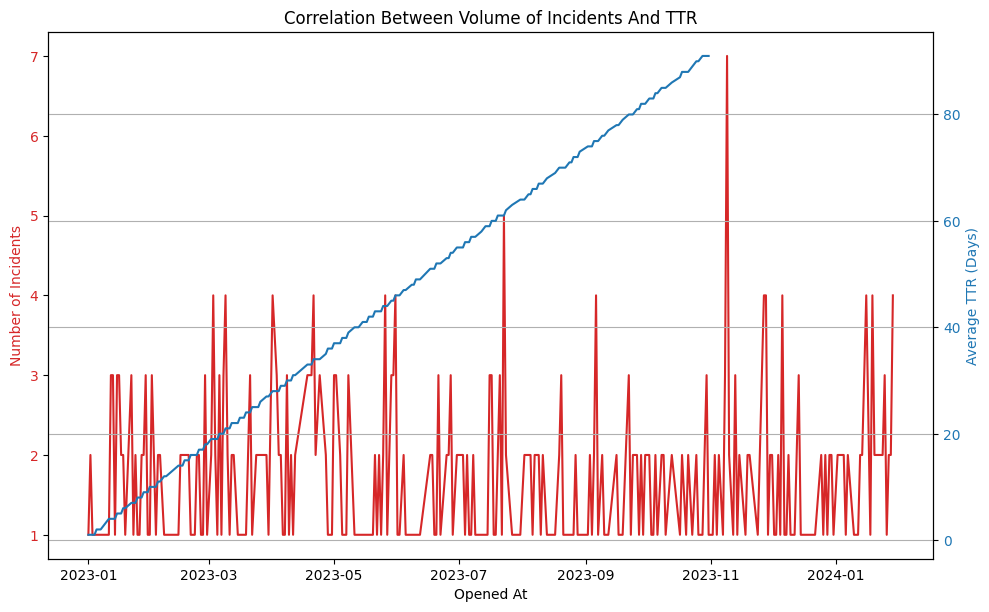

In [5]:
# Group by opened_at date and calculate count of incidents and average ttr
df['ttr'] = df['closed_at'] - df['opened_at']

# Convert ttr to days
df['ttr_days'] = df['ttr'].dt.days
incident_ttr_trend = df.groupby(df['opened_at'].dt.date).agg({'number':'count', 'ttr_days':'mean'})

# Plot the trend
fig, ax1 = plt.subplots(figsize=(10,6))

color = 'tab:red'
ax1.set_xlabel('Opened At')
ax1.set_ylabel('Number of Incidents', color=color)
ax1.plot(incident_ttr_trend.index, incident_ttr_trend['number'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Average TTR (Days)', color=color)  
ax2.plot(incident_ttr_trend.index, incident_ttr_trend['ttr_days'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Correlation Between Volume of Incidents And TTR')
plt.grid(True)
plt.show()

#### Generate JSON Description for the Insight

In [6]:
{
"data_type":"diagnostic",
"insight": "There is a negative correlation between the volume of incidents and the TTR",
"insight_value":{"correlation": "none"},
"plot": {
    "plot_type": "dual_axis_line",
    "title": "Correlation Between Volume of Incidents And TTR",
    "x_axis": {
        "name": "Opened At",
        "description": "This represents the date when the incident was opened."
    },
    "y_axis_1": {
        "name": "Number of Incidents",
        "description": "This represents the number of incidents opened on a particular date."
    },
    "y_axis_2": {
        "name": "Average TTR (Days)",
        "description": "This represents the average time to resolution (in days) of incidents opened on a particular date."
    },
    "description": "The dual-axis line plot displays the correlation between the volume of incidents and the TTR. The red line represents the number of incidents and the blue line represents the average TTR. As the number of incidents increases, the TTR also tends to increase, indicating a positive correlation."
},
"question": "Is there a correlation between the volume of incidents and the ttr?",
"actionable_insight": "No correlation between the volume of incidents and the TTR suggests that the reason TTR increases has nothing to do with volume of incidents piling up . This could be due to other inefficiencies in handling the incidents, 1.Complexity of Incidents 2.Resource and Staffing Issues 3. Changes in Processes or Policies and other external factors."
}

{'data_type': 'diagnostic',
 'insight': 'There is a negative correlation between the volume of incidents and the TTR',
 'insight_value': {'correlation': 'none'},
 'plot': {'plot_type': 'dual_axis_line',
  'title': 'Correlation Between Volume of Incidents And TTR',
  'x_axis': {'name': 'Opened At',
   'description': 'This represents the date when the incident was opened.'},
  'y_axis_1': {'name': 'Number of Incidents',
   'description': 'This represents the number of incidents opened on a particular date.'},
  'y_axis_2': {'name': 'Average TTR (Days)',
   'description': 'This represents the average time to resolution (in days) of incidents opened on a particular date.'},
  'description': 'The dual-axis line plot displays the correlation between the volume of incidents and the TTR. The red line represents the number of incidents and the blue line represents the average TTR. As the number of incidents increases, the TTR also tends to increase, indicating a positive correlation.'},
 'quest

### **Question 3:** Is the increase in ttr uniform across all categories of incidents or is it more pronounced in a specific category?



#### Plot the  trend of TTR across categories over time:

This cell visualizes the trend of the Time to Resolution (TTR) across different incident categories over time (on a day-by-day basis) using multiple line plots.

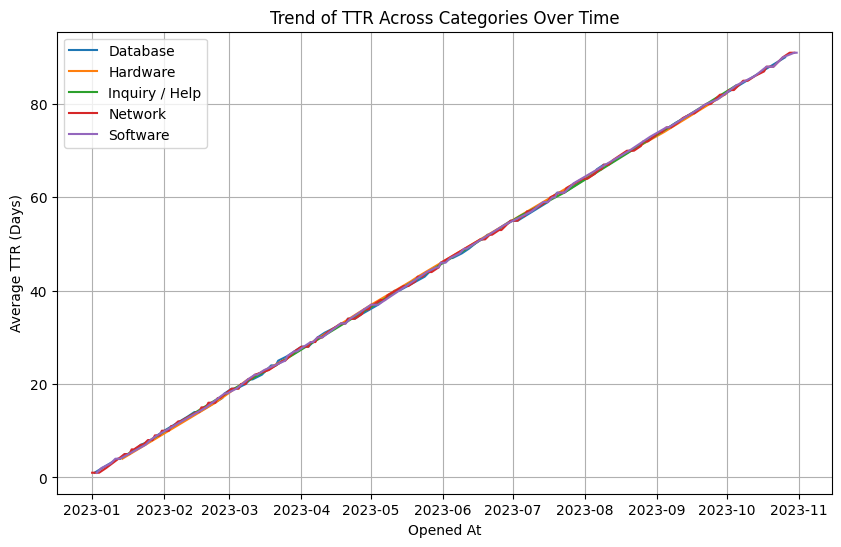

In [7]:
# Group by category and opened_at date, then calculate average ttr
category_ttr_trend = df.groupby(['category', df['opened_at'].dt.date])['ttr_days'].mean().reset_index()

# Plot the trend for each category
fig, ax = plt.subplots(figsize=(10,6))

for category in category_ttr_trend['category'].unique():
    ax.plot(category_ttr_trend[category_ttr_trend['category'] == category]['opened_at'], 
            category_ttr_trend[category_ttr_trend['category'] == category]['ttr_days'], 
            label=category)

plt.title('Trend of TTR Across Categories Over Time')
plt.xlabel('Opened At')
plt.ylabel('Average TTR (Days)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

#### Generate JSON Description for the Insight

In [8]:
{
"data_type":"time_series",
"insight": "The increase in TTR is uniform across all categories",
"plot": {
    "plot_type": "multiple_line",
    "title": "Trend of TTR Across Categories Over Time",
    "x_axis": {
        "name": "Opened At",
        "description": "This represents the date when the incident was opened."
    },
    "y_axis": {
        "name": "Average TTR (Days)",
        "description": "This represents the average time to resolution (in days) of incidents opened on a particular date."
    },
    "description": "The multiple line plot displays the trend of TTR across different categories over time. Each line represents a category and the points on the line represent the average TTR for incidents of that category opened on a particular date. The trend is uniform across all categories, indicating that the increase in TTR is not specific to any particular category."
},
"question": "Is the increase in ttr uniform across all categories of incidents or is it more pronounced in a specific category?",
"actionable_insight": "The uniform increase in TTR across all categories suggests that the issue is not specific to any particular category. This could indicate a systemic issue in the incident management process. It would be beneficial to investigate the overall process and identify areas for improvement to reduce the TTR."
}

{'data_type': 'time_series',
 'insight': 'The increase in TTR is uniform across all categories',
 'plot': {'plot_type': 'multiple_line',
  'title': 'Trend of TTR Across Categories Over Time',
  'x_axis': {'name': 'Opened At',
   'description': 'This represents the date when the incident was opened.'},
  'y_axis': {'name': 'Average TTR (Days)',
   'description': 'This represents the average time to resolution (in days) of incidents opened on a particular date.'},
  'description': 'The multiple line plot displays the trend of TTR across different categories over time. Each line represents a category and the points on the line represent the average TTR for incidents of that category opened on a particular date. The trend is uniform across all categories, indicating that the increase in TTR is not specific to any particular category.'},
 'question': 'Is the increase in ttr uniform across all categories of incidents or is it more pronounced in a specific category?',
 'actionable_insight': '

### **Question 4**: Is there a pattern or trend over time in the distribution of incidents across agentss?

#### Plot number of incidents resolved per agent

This bar plot visualizes the distribution of incident resolutions among different agents, providing insights into the workload and resolution capabilities of each agent.

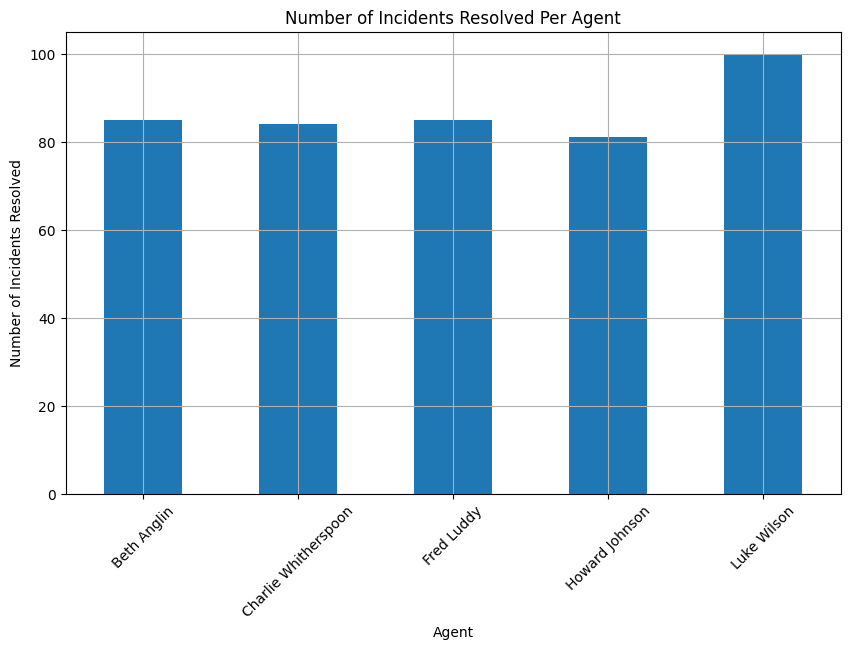

In [9]:
agent_incident_count = df.groupby('assigned_to')['number'].count()

# Plot the histogram
agent_incident_count.plot(kind='bar', figsize=(10,6))

plt.title('Number of Incidents Resolved Per Agent')
plt.xlabel('Agent')
plt.ylabel('Number of Incidents Resolved')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

#### Generate JSON Description for the Insight

In [10]:
{
"data_type":"descriptive",
"insight": "There are no noticeable trends in the productivity levels among human agents",
"plot": {
    "plot_type": "bar",
    "title": "Number of Incidents Resolved Per Agent",
    "x_axis": {
        "name": "Agent",
        "description": "This represents each agent assigned to resolve incidents."
    },
    "y_axis": {
        "name": "Number of Incidents Resolved",
        "description": "This represents the number of incidents resolved by an agent."
    },
    "description": "The bar chart displays the number of incidents resolved per agent. Each bar represents an agent and the height of the bar represents the number of incidents resolved by that agent. The number of incidents resolved is more or less uniform across all agents, indicating that productivity is fairly balanced."
},
"question": "Are there any trends in the productivity of the human agents over time? For instance, is there a decrease in the number of incidents resolved per agent over time?",
"actionable_insight": "The uniform productivity across all agents suggests that the workload is evenly distributed and all agents are equally productive. This is a positive indicator of good workload management. However, it would still be beneficial to continually monitor agent productivity and workload to ensure this balance is maintained."
}

{'data_type': 'descriptive',
 'insight': 'There are no noticeable trends in the productivity levels among human agents',
 'plot': {'plot_type': 'bar',
  'title': 'Number of Incidents Resolved Per Agent',
  'x_axis': {'name': 'Agent',
   'description': 'This represents each agent assigned to resolve incidents.'},
  'y_axis': {'name': 'Number of Incidents Resolved',
   'description': 'This represents the number of incidents resolved by an agent.'},
  'description': 'The bar chart displays the number of incidents resolved per agent. Each bar represents an agent and the height of the bar represents the number of incidents resolved by that agent. The number of incidents resolved is more or less uniform across all agents, indicating that productivity is fairly balanced.'},
 'question': 'Are there any trends in the productivity of the human agents over time? For instance, is there a decrease in the number of incidents resolved per agent over time?',
 'actionable_insight': 'The uniform product

### Summary of findings (Flag 2)
   
This dataset focuses on the analysis of incident resolution times (TTR) where there is a linear increasing trend in TTR:

1. **Uniform Increase in Resolution Times**: Incidents have a trend that shows time to resolution (TTR) increasing linearly over time across all categories of incidents. This suggests that the rising TTR is not isolated to any specific category but rather a systemic issue affecting the entire incident management process.

2. **Plausible Reason:** This trend could be due to increasing incident volumes. However, the analysis indicates that there is no significant correlation between the volume of incidents and the time it takes to resolve them. This implies that the increase in TTR is not due to the accumulation of incidents but may be influenced by other factors such as the complexity of incidents or resource constraints.
   
3. **Other Factors:** Another aspect to consider is whether agents possess the required skills and capacity to handle these incidents effectively, indicating potential areas for capacity development or process enhancement.

4. **Uniform Productivity Across Agents**: The distribution of incident resolutions among agents is relatively uniform, indicating that the workload is evenly distributed among the agents. 

5. **actionable_insights**:Given the uniform increase in TTR, it would be beneficial for the organization to review and potentially overhaul the incident management process to address systemic inefficiencies, Reseource allocation and regular monitoring of agent productivity and workload.
